# Introduction

> Credit classification is one of the popular classification problems encountered by financial institutions. For example, when customers applies for a loan, financial institutions such as banks would like to predict the probability of default. In this section, we will be using the german credit rating dataset provided by Prof. Hofman. The data contains several attributes of persons who availed the credit.

> In this project, we will do Exploratory data analysis and we will build classification model to see class probability.

> This dataset is taken from University of california Irvin (UCI) machine learning repository.

# Features description

1. **checkin_acc** - status of exixsting cecking account
2. **duration** - duration of the credit given in months
3. **credit_history** - credit history
4. **amount** - amount of credit/loan
5. **savings_acc** - balance in savings acc
6. **present_emp_since** - employment in years
7. **inst_rate** - installment rate
8. **personal_Status** - marital status of applicant
9. **residing_since** - residing since in years
10. **age** - age in years
11. **inst_plans** - other installement plans of the applicant
12. **checkin_acc** (bal) - balance in checking account
13. **job** -  types of job of an applicant
14. **status** (Credit) - credit status

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from math import floor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv("German Credit Data.csv")
df.head()

,checkin_acc,duration,credit_history,amount,savings_acc,present_emp_since,inst_rate,personal_status,residing_since,age,inst_plans,num_credits,job,status
0,A11,6,A34,1169,A65,A75,4,A93,4,67,A143,2,A173,0
1,A12,48,A32,5951,A61,A73,2,A92,2,22,A143,1,A173,1
2,A14,12,A34,2096,A61,A74,2,A93,3,49,A143,1,A172,0
3,A11,42,A32,7882,A61,A74,2,A93,4,45,A143,1,A173,0
4,A11,24,A33,4870,A61,A73,3,A93,4,53,A143,2,A173,1


# Exploratory data analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   checkin_acc        1000 non-null   object
 1   duration           1000 non-null   int64 
 2   credit_history     1000 non-null   object
 3   amount             1000 non-null   int64 
 4   savings_acc        1000 non-null   object
 5   present_emp_since  1000 non-null   object
 6   inst_rate          1000 non-null   int64 
 7   personal_status    1000 non-null   object
 8   residing_since     1000 non-null   int64 
 9   age                1000 non-null   int64 
 10  inst_plans         1000 non-null   object
 11  num_credits        1000 non-null   int64 
 12  job                1000 non-null   object
 13  status             1000 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 109.5+ KB


             status
good credit     700
bad credit      300


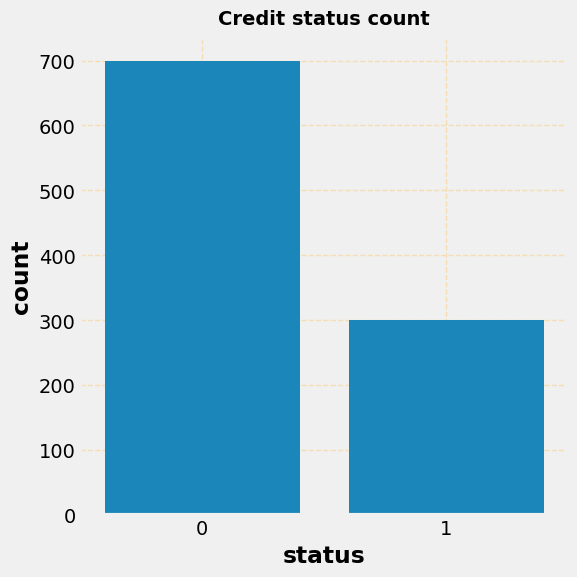

In [4]:
status_df=pd.DataFrame(data=np.array(df['status'].value_counts()),
                   index=['good credit','bad credit'],
                   columns=['status'])
print(status_df)

plt.figure(figsize=(6,6))
sns.countplot(x='status', data=df)
plt.grid(visible=True,color='wheat',
                 linestyle='--')
plt.title("Credit status count")
plt.show()

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
inst_rate,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residing_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
num_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
status,1000.0,0.300,0.458487,0.0,0.0,0.0,1.00,1.0


In [7]:
from IPython.display import clear_output

# Select only numerical columns before calculating the correlation
numerical_df = df.select_dtypes(include=np.number)
display(numerical_df.corr())
clear_output()

In [8]:
columns = list(df.columns)
columns

['checkin_acc',
 'duration',
 'credit_history',
 'amount',
 'savings_acc',
 'present_emp_since',
 'inst_rate',
 'personal_status',
 'residing_since',
 'age',
 'inst_plans',
 'num_credits',
 'job',
 'status']

In [9]:
def dataframe_columns(df, car=10):
    # cat columns
    cat_col = [col for col in df.columns if df[col].dtypes == 'object']
    print("length of cat_col: ", len(cat_col))
    print("categorical cols are : ", cat_col)
    print("##########################################################")

    # num columns
    num_col = [col for col in df.columns if df[col].dtypes == 'int64']
    print("length of num_col: ", len(num_col))
    print("numerical cols are: ", num_col)
    print("##########################################################")
    # cardinality of columns
    num_but_cat = [col for col in df.columns if df[col].dtypes == 'int64' and df[col].nunique() < car]
    print("length of num but cat cols: ", len(num_but_cat))
    print("Num but categorical cols are: ", num_but_cat)
    print("##########################################################")
    # continuous featues
    cont_num_col = [col for col in num_col if col not in num_but_cat]
    print("length of continuos cols: ", len(cont_num_col))
    print("continus features: ", cont_num_col)
    print("##########################################################")
    # cat cardinality cols
    low_cat = [col for col in df.columns if df[col].dtypes == 'object' and df[col].nunique() < car]
    print("length of cat_col: ", len(low_cat))
    print("Low categorical features: ", low_cat)
    print("##########################################################")
    # high cardinality cols
    high_Cat = [col for col in cat_col if col not in low_cat]
    print("lenght of high_Cat is: ", len(high_Cat))

    return cat_col, num_col, num_but_cat, cont_num_col

In [10]:
cat_col, num_col, num_but_cat, cont_num_col = dataframe_columns(df)

length of cat_col:  7
categorical cols are :  ['checkin_acc', 'credit_history', 'savings_acc', 'present_emp_since', 'personal_status', 'inst_plans', 'job']
##########################################################
length of num_col:  7
numerical cols are:  ['duration', 'amount', 'inst_rate', 'residing_since', 'age', 'num_credits', 'status']
##########################################################
length of num but cat cols:  4
Num but categorical cols are:  ['inst_rate', 'residing_since', 'num_credits', 'status']
##########################################################
length of continuos cols:  3
continus features:  ['duration', 'amount', 'age']
##########################################################
length of cat_col:  7
Low categorical features:  ['checkin_acc', 'credit_history', 'savings_acc', 'present_emp_since', 'personal_status', 'inst_plans', 'job']
##########################################################
lenght of high_Cat is:  0


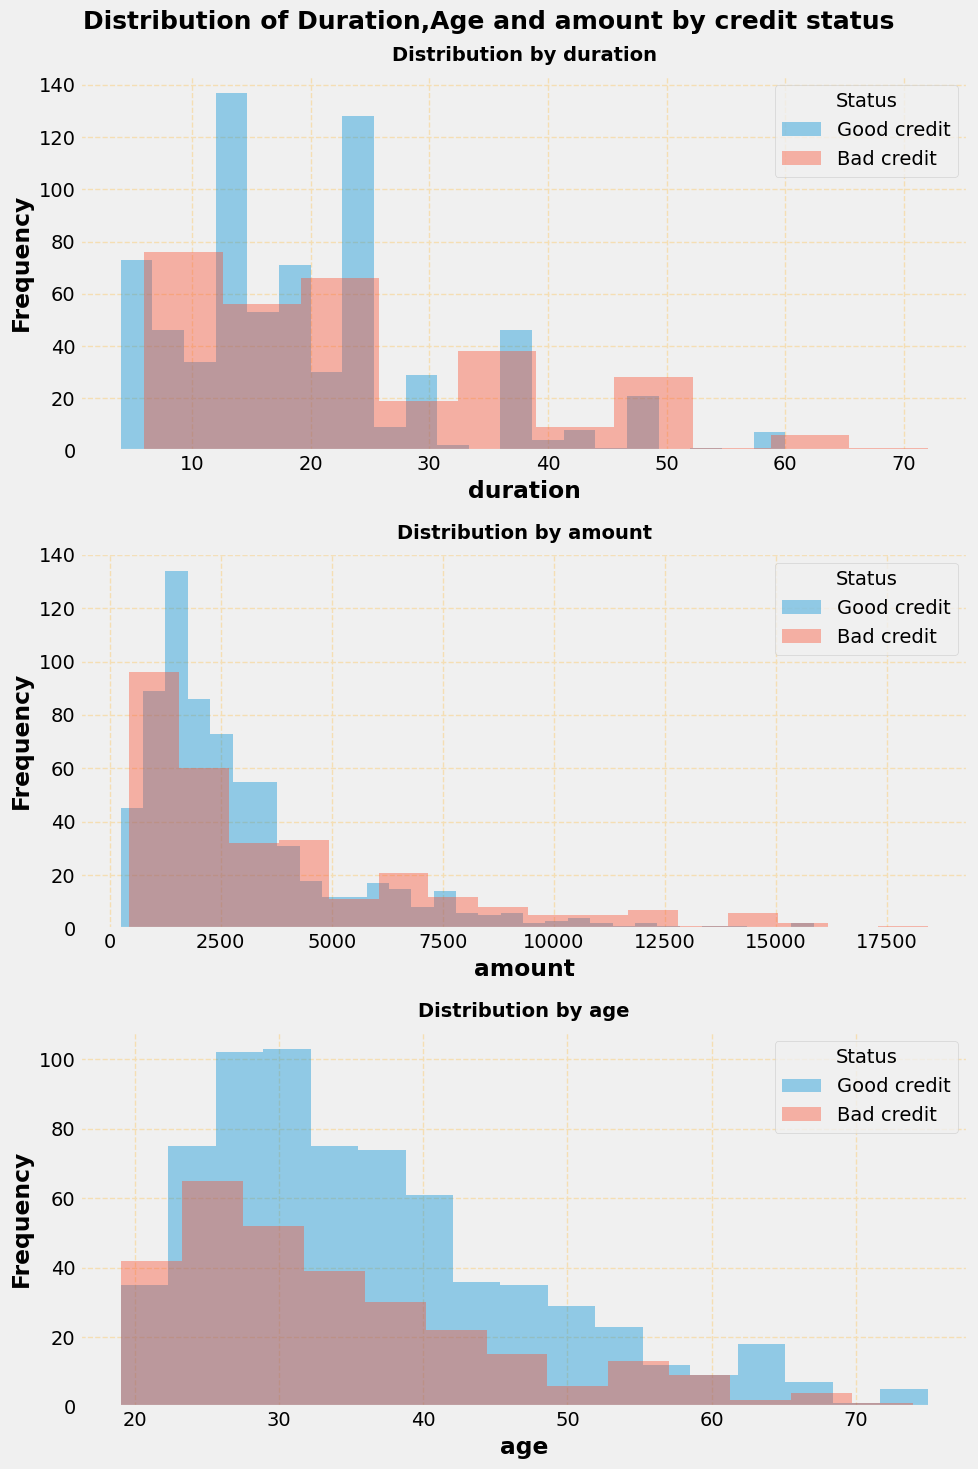

In [11]:
cont_num_col

fig, ax = plt.subplots(3, figsize=(10,15))
for idx, col in enumerate(cont_num_col):
    sns.distplot(x=df[df['status'] == 0][col],
                 kde=False,
                 label='Good credit',
                 ax=ax[idx])
    sns.distplot(x=df[df['status'] == 1][col],
                 kde=False,
                 label='Bad credit',
                 ax=ax[idx])
    ax[idx].legend(title='Status')
    ax[idx].set_xlabel(col)
    ax[idx].set_ylabel("Frequency")
    ax[idx].grid(visible=True,
                 color='wheat',
                 linestyle='--')
    ax[idx].set_title("Distribution by {}".format(col))

plt.suptitle("Distribution of Duration,Age and amount by credit status",
             fontsize=18,
             fontweight='bold')
fig.tight_layout()
plt.show()

**> WORKFLOW**

1. count plots by cat and num_but_cat col
2. point plot by cat and num_Cat with status cols
3. box plot by status vs num col
4. ouliers detection
5. correlation matrix
6. scaling data

> model building:

1. logistic regression
2. SVM
3. k-NN
4. Naive bayes
5. RF XGB

In [12]:
# count plots by cat and num but cat col

def count_plot(var):
    #printing values of variable
    new = df[var].value_counts()

    plt.figure(figsize=(8,5))
    sns.countplot(x=var,
                  data=df)
    plt.grid(visible=True,
                 color='wheat',
                 linestyle='--')
    plt.title(var)
    plt.show()
    print("{}:\n{}".format(var,new))

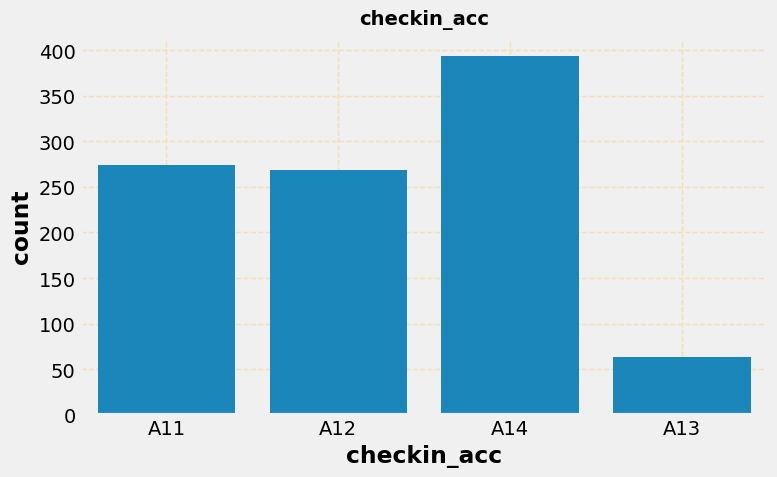

checkin_acc:
checkin_acc
A14    394
A11    274
A12    269
A13     63
Name: count, dtype: int64


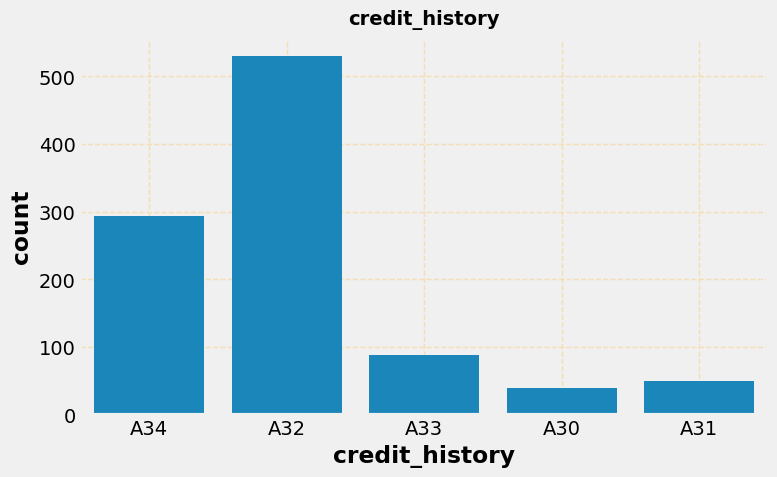

credit_history:
credit_history
A32    530
A34    293
A33     88
A31     49
A30     40
Name: count, dtype: int64


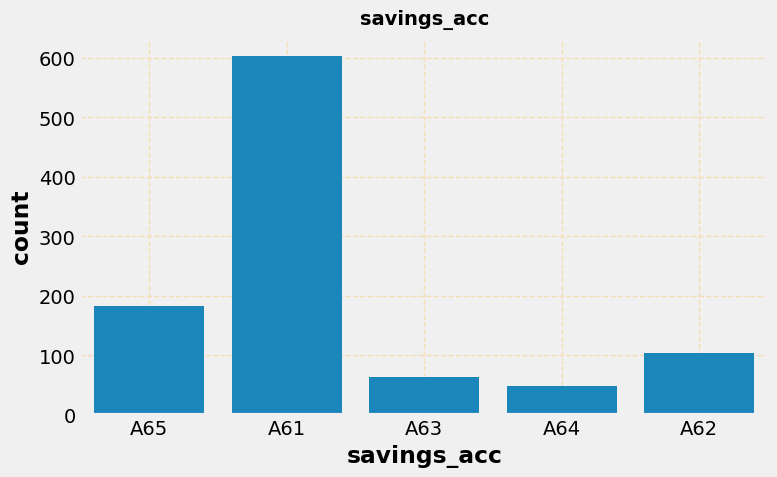

savings_acc:
savings_acc
A61    603
A65    183
A62    103
A63     63
A64     48
Name: count, dtype: int64


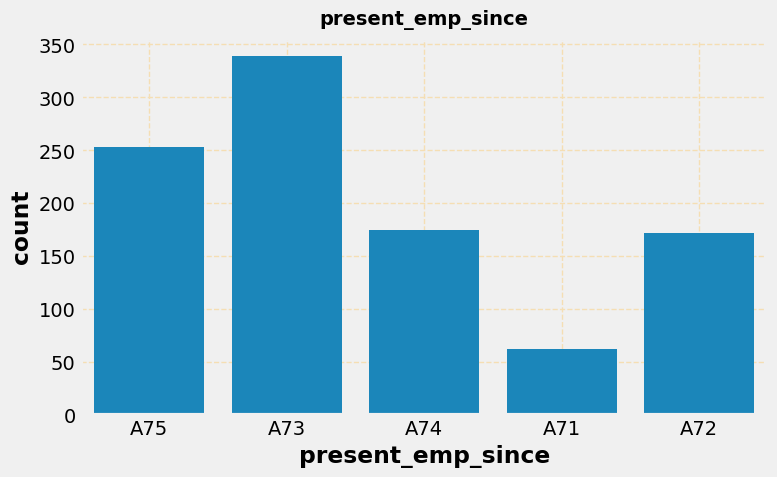

present_emp_since:
present_emp_since
A73    339
A75    253
A74    174
A72    172
A71     62
Name: count, dtype: int64


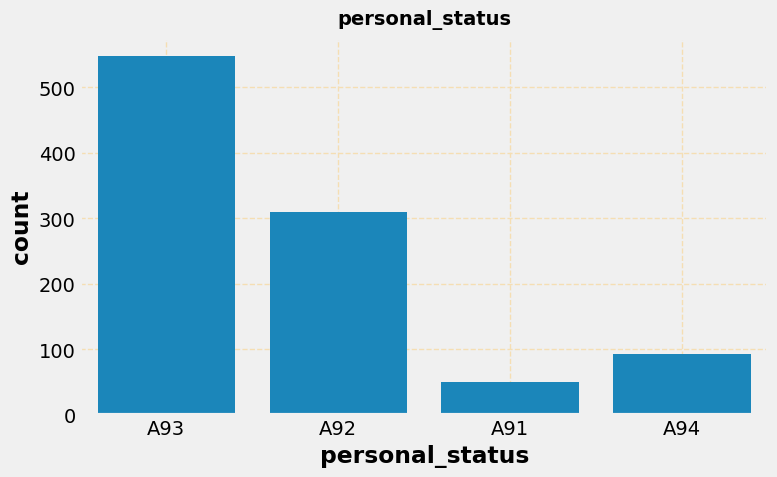

personal_status:
personal_status
A93    548
A92    310
A94     92
A91     50
Name: count, dtype: int64


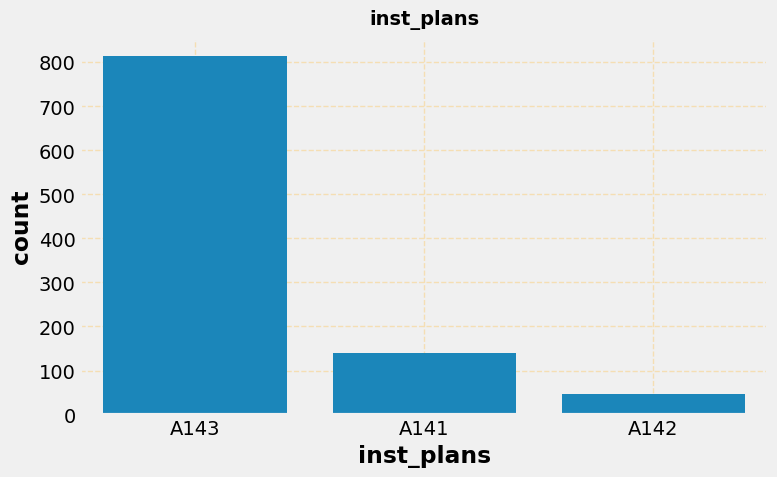

inst_plans:
inst_plans
A143    814
A141    139
A142     47
Name: count, dtype: int64


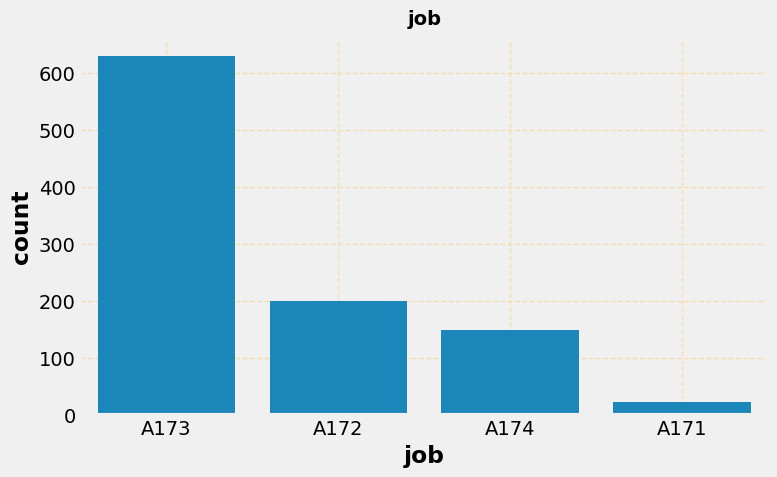

job:
job
A173    630
A172    200
A174    148
A171     22
Name: count, dtype: int64


In [13]:
for var in cat_col:
    count_plot(var)

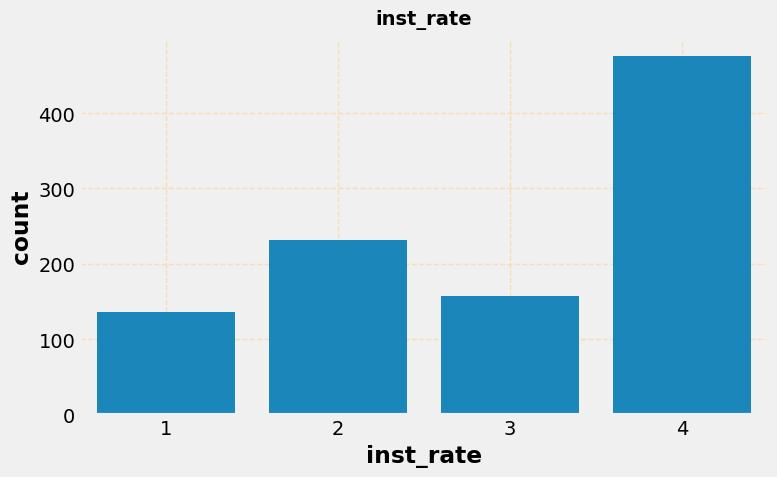

inst_rate:
inst_rate
4    476
2    231
3    157
1    136
Name: count, dtype: int64


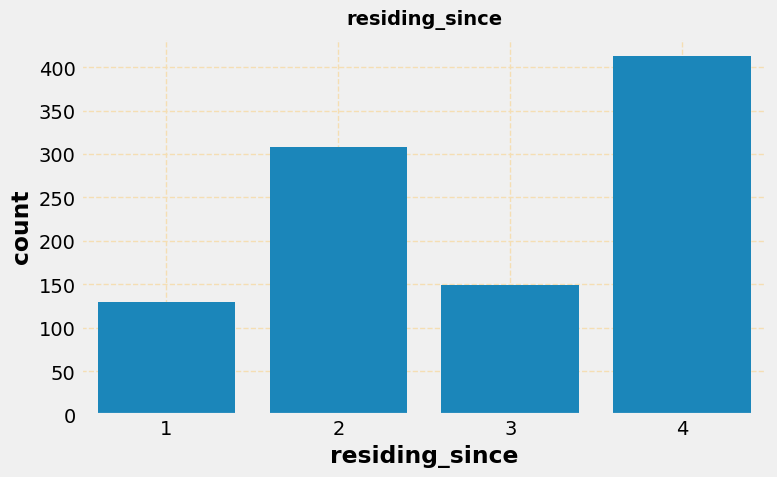

residing_since:
residing_since
4    413
2    308
3    149
1    130
Name: count, dtype: int64


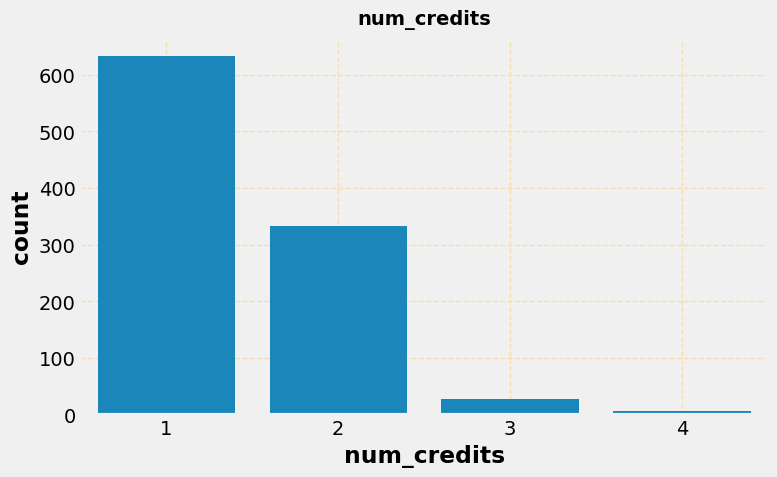

num_credits:
num_credits
1    633
2    333
3     28
4      6
Name: count, dtype: int64


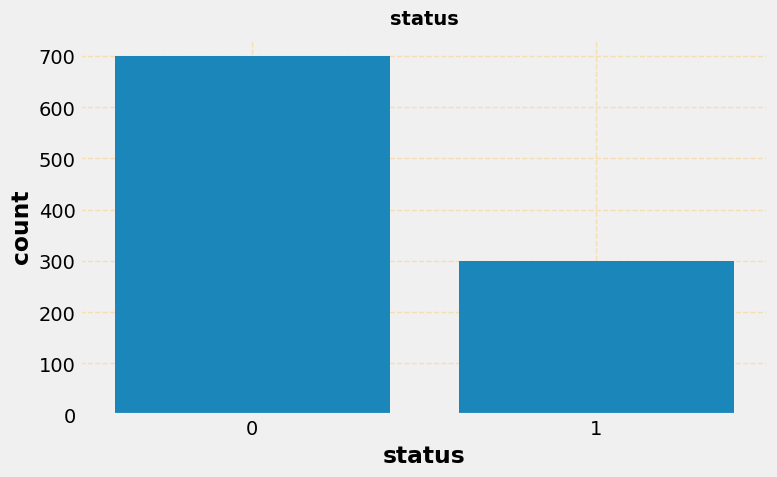

status:
status
0    700
1    300
Name: count, dtype: int64


In [14]:
for var in num_but_cat:
    count_plot(var)

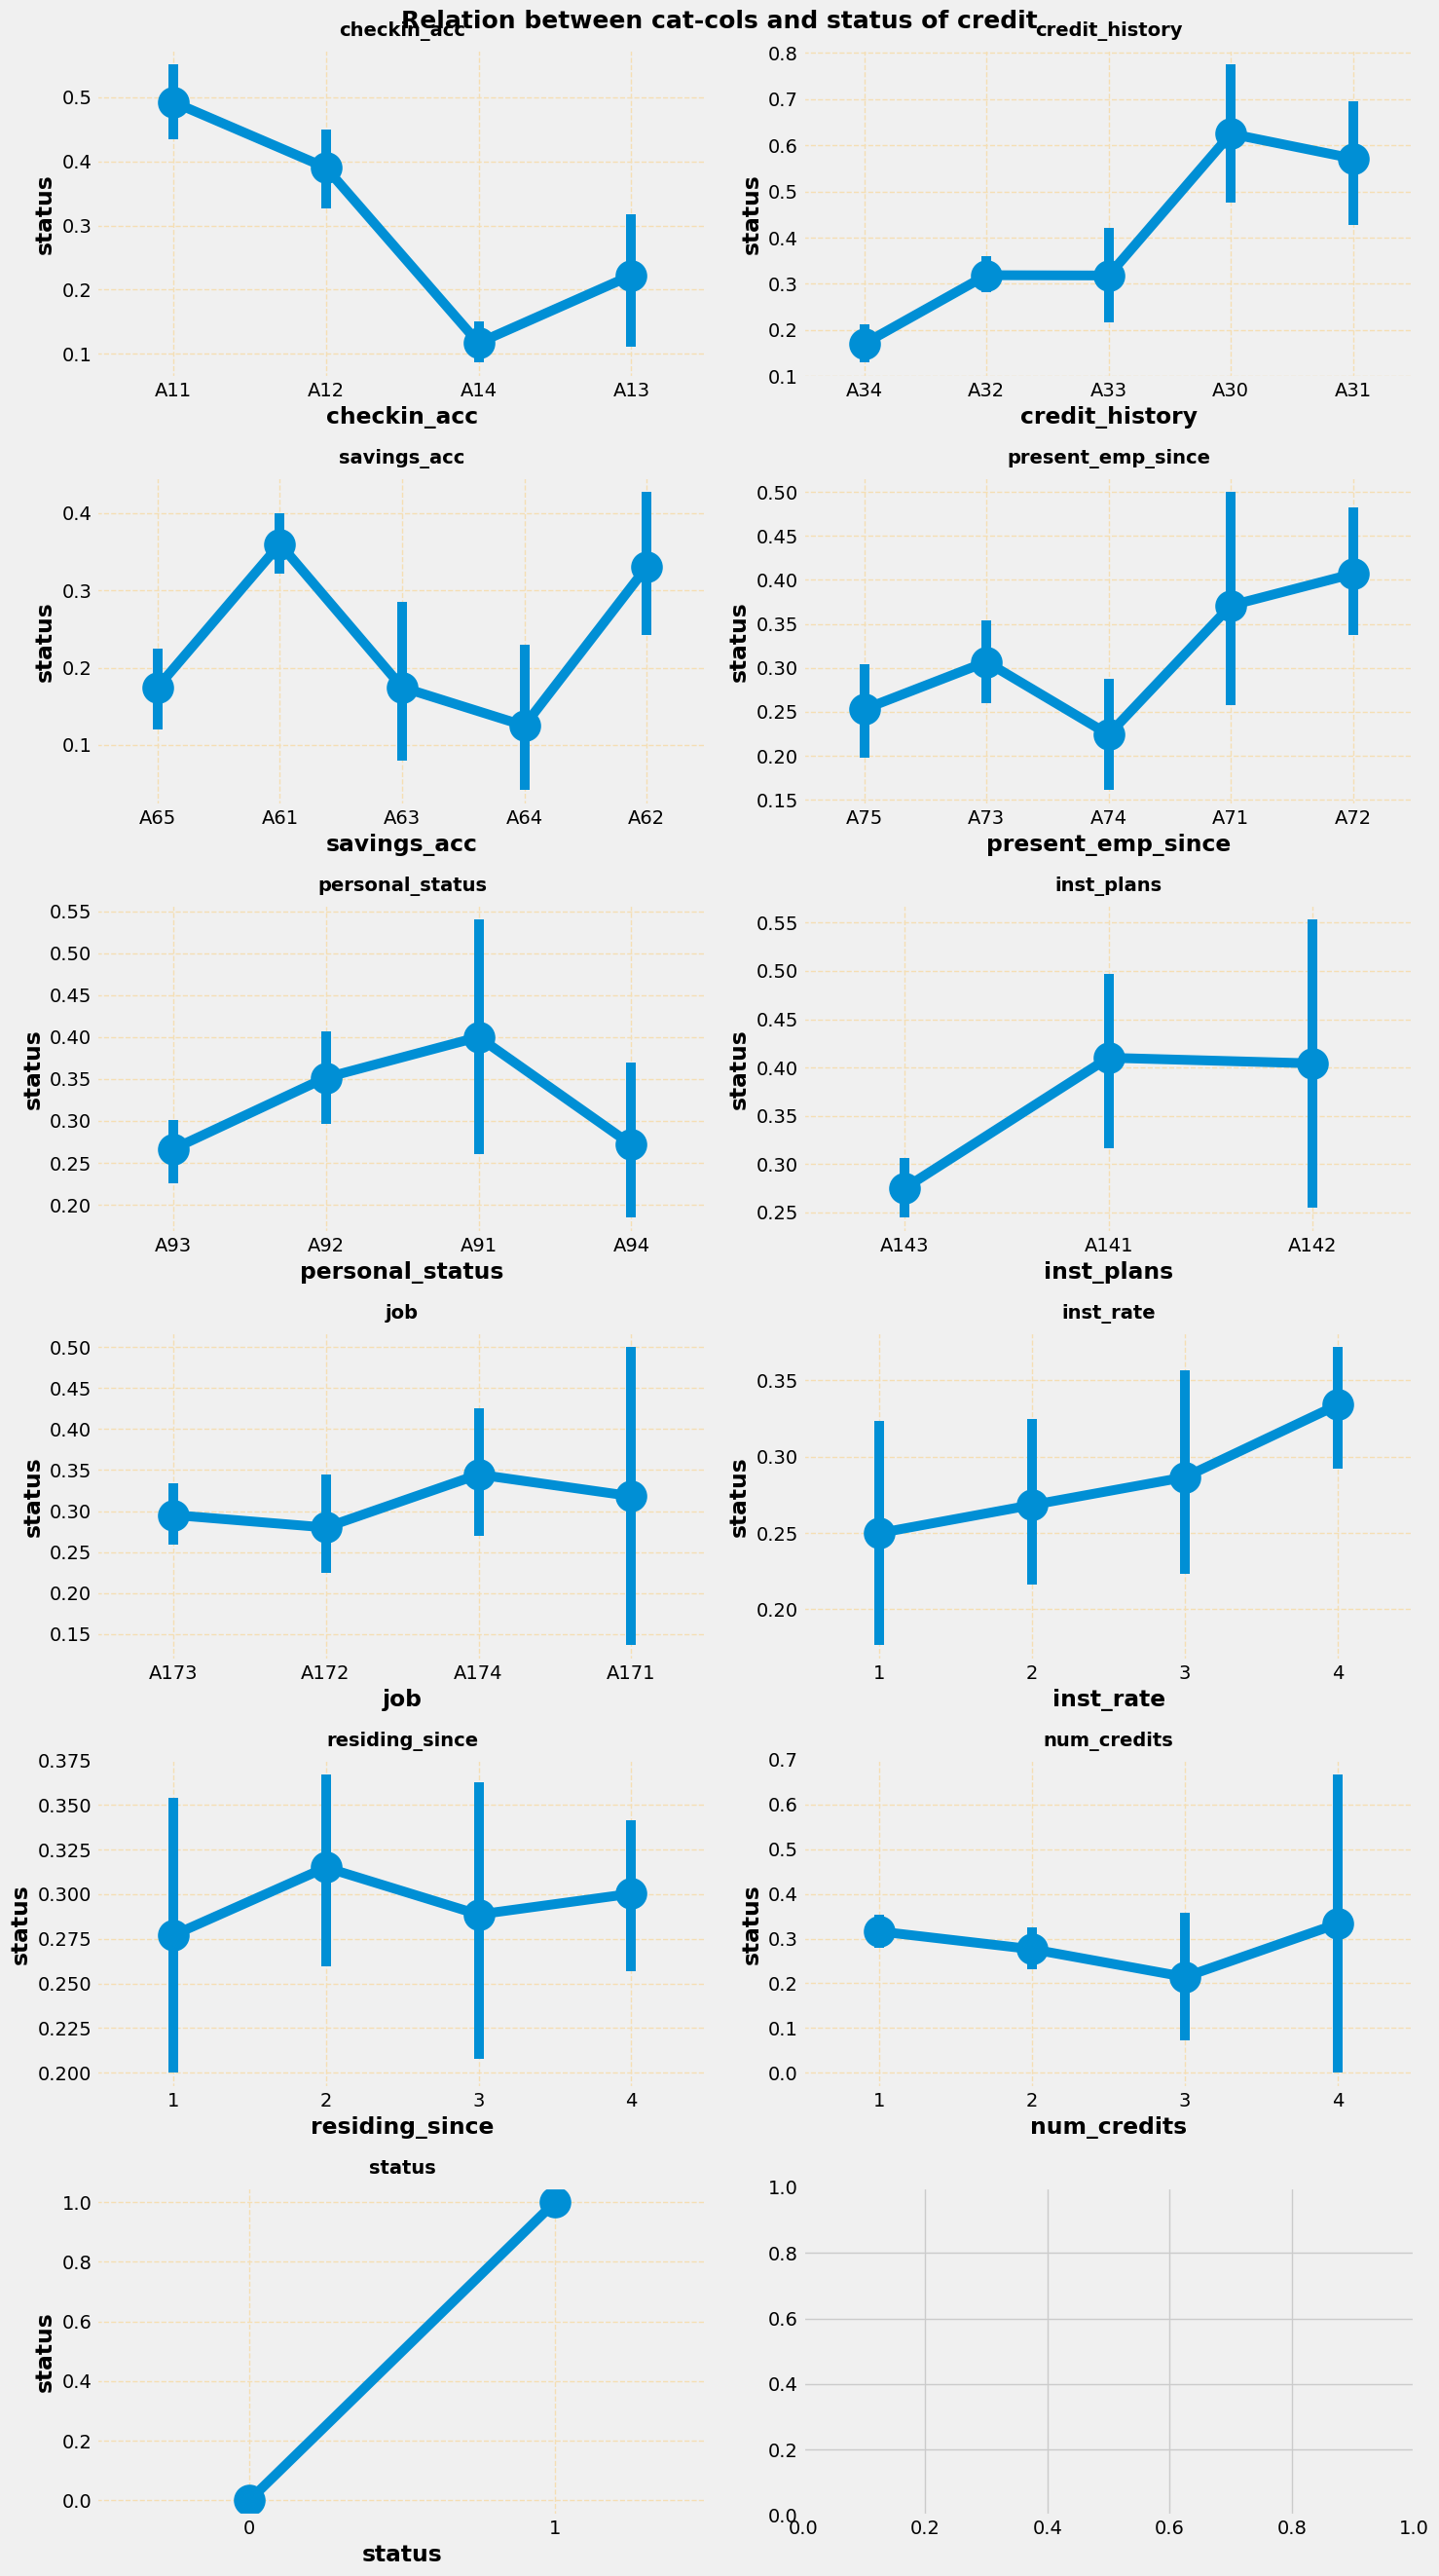

In [15]:
new_cat_col = cat_col + num_but_cat

fig, ax = plt.subplots(6,2, figsize=(15,27))
for idx, var in enumerate(new_cat_col):
    sns.pointplot(x=var, y='status', data=df, ax=ax[floor(idx/2), idx%2])
    ax[floor(idx/2), idx%2].grid(visible=True,
                                linestyle='--',
                                color='wheat')
    ax[floor(idx/2), idx%2].set_title(var)

plt.suptitle("Relation between cat-cols and status of credit",
             fontsize=18,
             fontweight='bold')
fig.tight_layout()
plt.show()

> job, num_credits, and residing_since do not affects status of credits, these columns can be removed

> checking acc and creidt history affect the credit rating

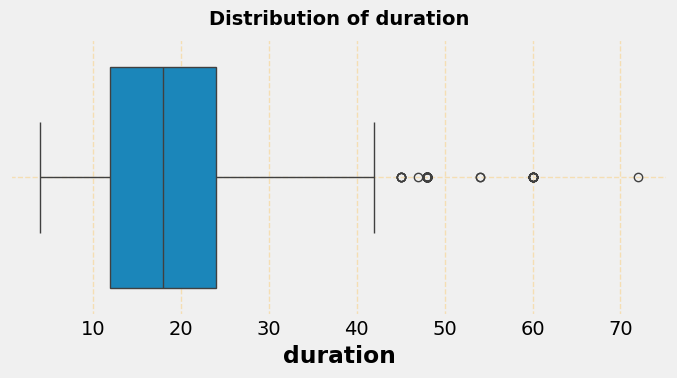

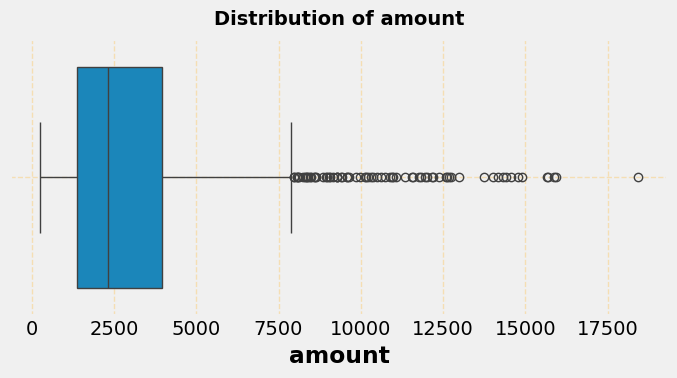

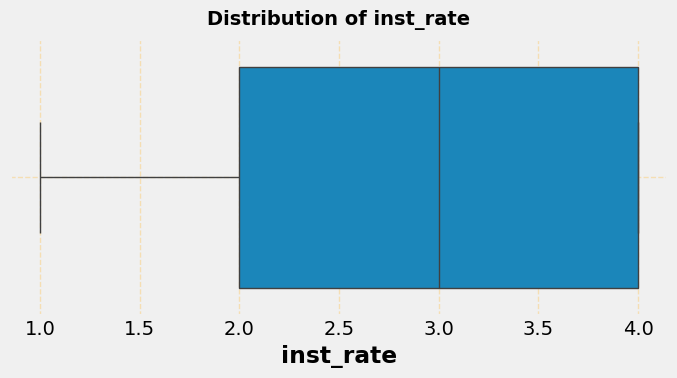

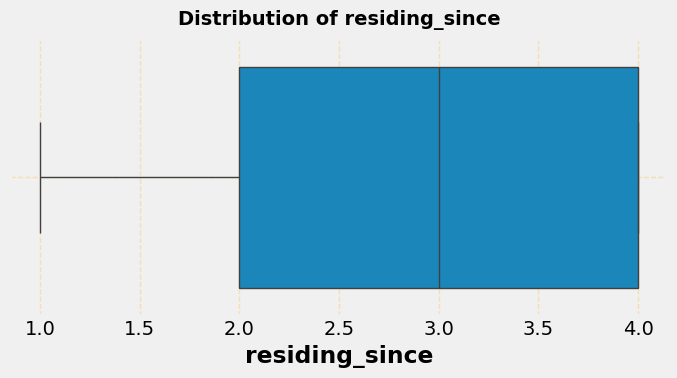

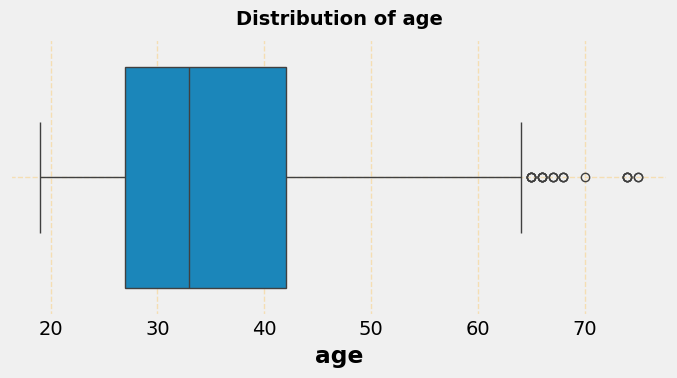

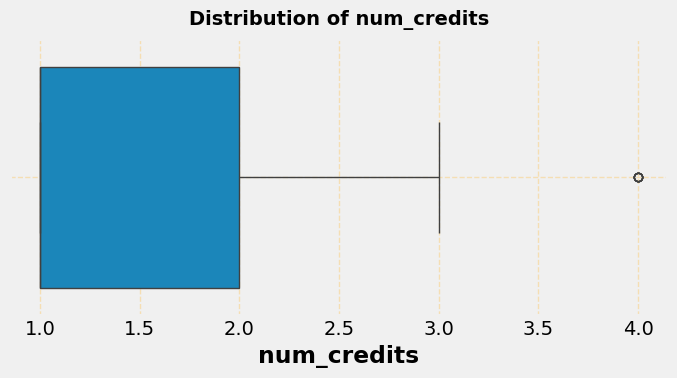

In [16]:
cols = list([col for col in num_col if col != 'status'])

for idx, col in enumerate(cols):
    plt.figure(idx, figsize=(7,4))
    sns.boxplot(x=col, data=df)
    plt.grid(visible=True,
             color='wheat',
             linestyle='--')
    plt.title("Distribution of {}".format(col))
    plt.show()

> outliers are there in age, duration, amount and num_credits columns

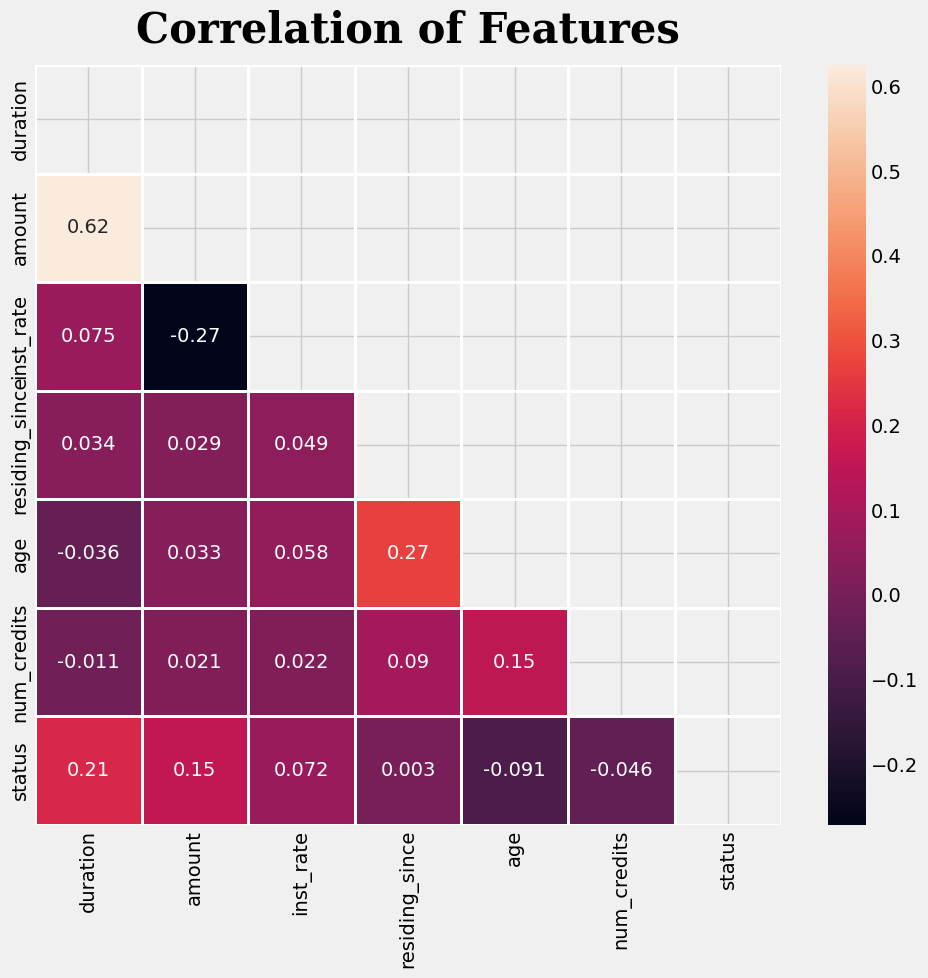

In [18]:
# correlation matrix of numerical cols
plt.figure(figsize=(10,10))
mask = np.triu(np.ones_like(df.select_dtypes(include=np.number).corr(), dtype=np.bool))
heatmap = sns.heatmap(df.select_dtypes(include=np.number).corr(), mask=mask, annot=True, linewidth=2)
heatmap.set_title('Correlation of Features',
              fontdict={'fontsize':30, 'fontfamily' : 'serif', 'fontweight' : 'bold'},
              pad=16)
plt.show()

# Baseline Logistic regression model

In [19]:
# features to be removed
remove_col = ['job', 'residing_since','num_credits']
feature_encode = ['checkin_acc', 'credit_history', 'savings_acc', 'present_emp_since', 'personal_status', 'inst_plans']

# creat new copy of df
new_df = df.copy()
new_df.drop(remove_col, inplace=True, axis=1)

#encode features
encode_df = pd.get_dummies(new_df, columns=feature_encode, drop_first=True)
encode_df.shape

#divide X and y columns
X = sm.add_constant(encode_df.drop('status', axis=1))
y = encode_df['status']

# split the train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750, 25), (250, 25), (750,), (250,))

In [23]:
# builing logit model using statsmodels api
# Convert boolean columns to integers
X_train = X_train.astype(int)
logit = sm.Logit(y_train, X_train)
logit_model = logit.fit()

# call the summary of logit model
logit_model.summary2()

Optimization terminated successfully.
         Current function value: 0.491087
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Logit
=====================================================================
Model:                Logit             Method:            MLE       
Dependent Variable:   status            Pseudo R-squared:  0.200     
Date:                 2025-08-06 07:47  AIC:               786.6299  
No. Observations:     750               BIC:               902.1317  
Df Model:             24                Log-Likelihood:    -368.31   
Df Residuals:         725               LL-Null:           -460.66   
Converged:            1.0000            LLR p-value:       9.2727e-27
No. Iterations:       6.0000            Scale:             1.0000    
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
const                  0.6851   0.9009  0.7605 0.4470 -1.0806  2.4508
duration               0.0198   0.0099  2.0034 0.0451  0.0004  0.0392
amount                 0.0001   0.0000  2.7532 0.0059  0.0000  0.0002
inst_rate              0.2998   0.0923  3.2492 0.0012  0.1190  0.4807
age                   -0.0207   0.0097 -2.1316 0.0330 -0.0398 -0.0017
checkin_acc_A12       -0.4740   0.2299 -2.0618 0.0392 -0.9246 -0.0234
checkin_acc_A13       -1.0892   0.4261 -2.5562 0.0106 -1.9244 -0.2541
checkin_acc_A14       -1.7400   0.2482 -7.0099 0.0000 -2.2265 -1.2535
credit_history_A31     0.0022   0.5530  0.0040 0.9968 -1.0816  1.0860
credit_history_A32    -0.6751   0.4182 -1.6141 0.1065 -1.4948  0.1446
credit_history_A33    -0.7744   0.4916 -1.5753 0.1152 -1.7379  0.1891
credit_history_A34    -1.3142   0.4474 -2.9371 0.0033 -2.1912 -0.4372
savings_acc_A62       -0.0579   0.3047 -0.1902 0.8492 -0.6550  0.5392
savings_acc_A63       -0.5081   0.4368 -1.1634 0.2447 -1.3642  0.3479
savings_acc_A64       -0.9595   0.5465 -1.7559 0.0791 -2.0306  0.1115
savings_acc_A65       -0.6328   0.2674 -2.3665 0.0180 -1.1570 -0.1087
present_emp_since_A72  0.0852   0.4038  0.2109 0.8329 -0.7063  0.8767
present_emp_since_A73 -0.0526   0.3746 -0.1405 0.8882 -0.7868  0.6815
present_emp_since_A74 -0.3982   0.4094 -0.9728 0.3307 -1.2006  0.4041
present_emp_since_A75 -0.1590   0.3948 -0.4029 0.6871 -0.9328  0.6147
personal_status_A92   -0.0475   0.4707 -0.1009 0.9196 -0.9700  0.8750
personal_status_A93   -0.5455   0.4635 -1.1770 0.2392 -1.4540  0.3629
personal_status_A94   -0.3277   0.5372 -0.6101 0.5418 -1.3806  0.7251
inst_plans_A142       -0.1739   0.4769 -0.3647 0.7153 -1.1086  0.7608
inst_plans_A143       -0.4974   0.2635 -1.8880 0.0590 -1.0138  0.0190
=====================================================================

"""

> As we can see inst_rate, amount, duration, age are some of the significant variables as per the logit models

In [24]:
# significant features
significant_fea = pd.DataFrame(logit_model.pvalues)
significant_fea[significant_fea[0] < 0.05].reset_index()

,index,0
0,duration,4.513145e-02
1,amount,5.902003e-03
2,inst_rate,1.157139e-03
3,age,3.304199e-02
4,checkin_acc_A12,3.922625e-02
5,checkin_acc_A13,1.058193e-02
6,checkin_acc_A14,2.384212e-12
7,credit_history_A34,3.312497e-03
8,savings_acc_A65,1.795713e-02


In [26]:
# validate with test data
# Convert X_test to integers
X_test = X_test.astype(int)

pred_df = pd.DataFrame({"actual": y_test,
                        "Predicted_prob": logit_model.predict(X_test)
                       })

pred_df['Predicted'] = pred_df['Predicted_prob'].map(lambda x: 1 if x>0.5 else 0)
pred_df

,actual,Predicted_prob,Predicted
521,1,0.560920,1
737,0,0.475072,0
740,0,0.591438,1
660,0,0.241501,0
411,0,0.105905,0
...,...,...,...
109,0,0.125747,0
430,0,0.019813,0
77,0,0.156455,0
84,0,0.288947,0


In [27]:
# confusion matrix
def confusion_matri(actual, predicted):
    cm = confusion_matrix(actual, predicted, labels=[1,0])
    tp, fp, fn, tn = cm.ravel()
    #plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='.2f',
                xticklabels =['Bad credit','Good credit'],
                yticklabels =['Bad credit','Good credit'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted lable')
    plt.title("Confusion Matrix")
    plt.show()
    return tn,fp,fn,tp

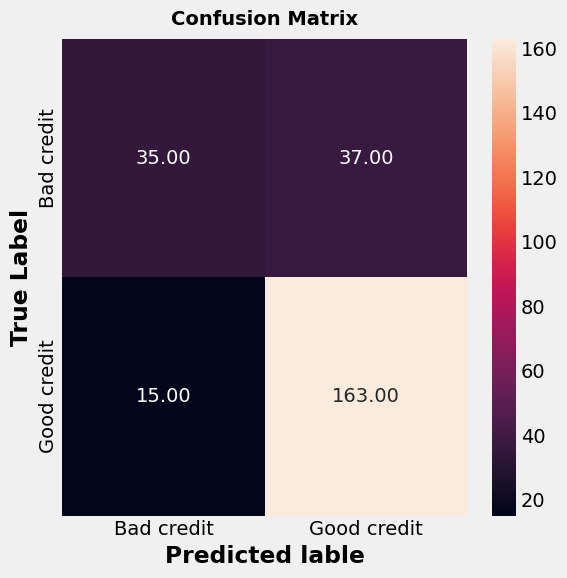

(np.int64(163), np.int64(37), np.int64(15), np.int64(35))

In [28]:
# confusion matrix of logit model
confusion_matri(pred_df['actual'], pred_df['Predicted'])

> here 0 = good and 1 = bad, TP = bad credit correctky classifed as bad

In [29]:
report = classification_report(pred_df['actual'], pred_df['Predicted'])
print(report)
print("#############################################################")
print("Accuracy score: ", accuracy_score(pred_df['actual'], pred_df['Predicted']))
print("Precision score: ", precision_score(pred_df['actual'], pred_df['Predicted']))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       178
           1       0.70      0.49      0.57        72

    accuracy                           0.79       250
   macro avg       0.76      0.70      0.72       250
weighted avg       0.78      0.79      0.78       250

#############################################################
Accuracy score:  0.792
Precision score:  0.7


> accuracy score is nearly 79% while precision is certainly low compared to accuracy.

> here classes are unbalanced and we are taking decision boundry as a 0.5 which is not resulting in right metrix.

> our cut-off probability shoud be changed.

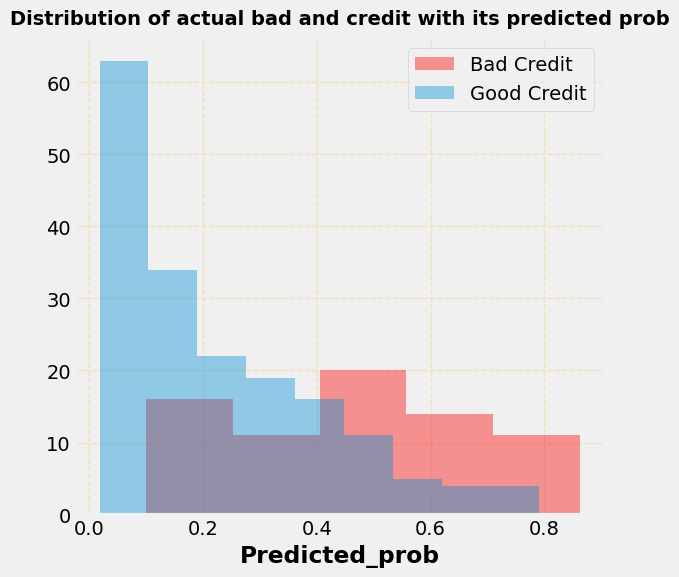

In [30]:
# let's plot actual value of class and predicted probability
plt.figure(figsize=(6,6))
sns.distplot(pred_df[pred_df['actual']==1]['Predicted_prob'], kde=False,
            label='Bad Credit', color='r')
sns.distplot(pred_df[pred_df['actual']==0]['Predicted_prob'], kde=False,
            label='Good Credit')

plt.title('Distribution of actual bad and credit with its predicted prob')
plt.grid(visible=True, color='wheat', linestyle='--')
plt.legend()
plt.show()

> here you can see that overlap is much higher than it should have been and due unbalanced actuall class distribution our 0.5 cut-off prob is not good.

In [31]:
# plotting roc-auc curve
def draw_roc(actual, proba):
    fpr, tpr, thresholds = roc_curve(actual, proba,drop_intermediate=False)
    auc_score = roc_auc_score(actual, proba)
    # plot the curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label="ROC curve(area={})".format(round(auc_score,2)))
    plt.plot([0,1],[0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(visible=True, color='wheat', linestyle='--')
    plt.legend(loc="lower right")
    plt.title("ROC-AUC Curve")
    plt.show()
    return fpr, tpr, thresholds

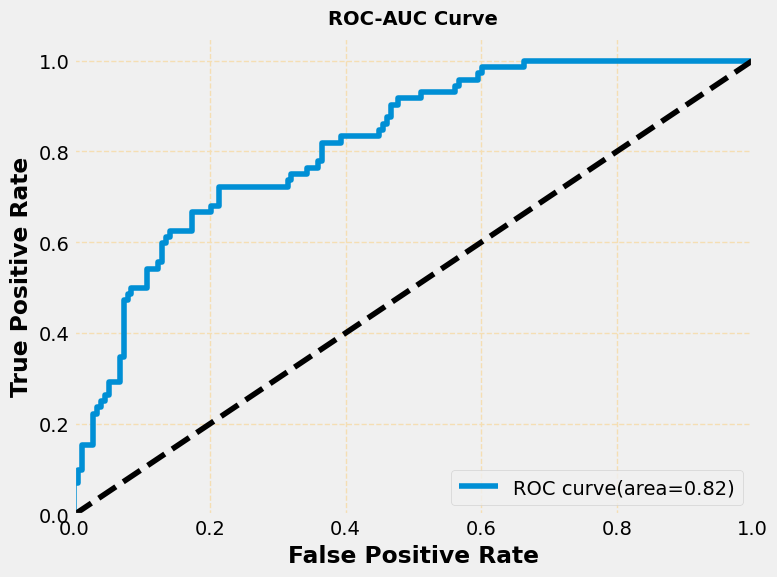

In [32]:
# roc-auc curve of logit model
fpr, tpr, thresholds = draw_roc(pred_df['actual'],pred_df['Predicted_prob'])

In [33]:
auc_score = round(roc_auc_score(pred_df['actual'],pred_df['Predicted_prob']),2)
print("AUC score of the model is: ", auc_score)

AUC score of the model is:  0.82


In [34]:
# Youden's index based approch to find cut-off probability
tpr_fpr = pd.DataFrame({'tpr': tpr,
                       'fpr': fpr,
                       'thresholds': thresholds}
                      )

tpr_fpr['Diff'] = tpr_fpr.tpr - tpr_fpr.fpr
tpr_fpr.sort_values(by='Diff', ascending=False).head()

,tpr,fpr,thresholds,Diff
90,0.722222,0.213483,0.370720,0.508739
91,0.722222,0.219101,0.365997,0.503121
92,0.722222,0.224719,0.362694,0.497503
89,0.708333,0.213483,0.374437,0.494850
79,0.666667,0.174157,0.401162,0.492509


> As per Youden's index maximum difference of tpr and fpr has the actual cutoff probability which **0.37** in this case

> youden's index formula = Max(p) = (sensitivity(p) + specifity(p) - 1)

>Which is nothing but the MAX(TPR-FPR)

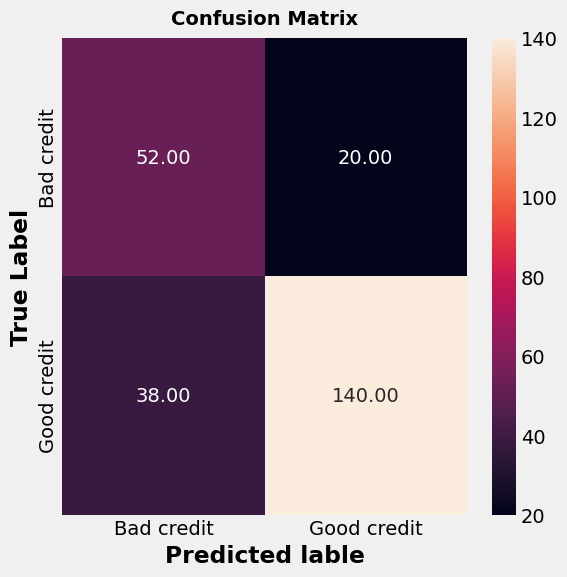

(np.int64(140), np.int64(20), np.int64(38), np.int64(52))

In [35]:
pred_df['Predicted_new'] = pred_df['Predicted_prob'].map(lambda x: 1 if x>0.37 else 0)

# new confution matrix
confusion_matri(pred_df['actual'], pred_df['Predicted_new'])

In [36]:
new_report = classification_report(pred_df['actual'], pred_df['Predicted_new'])
print(new_report)

print("#######################################################################")

print("Accuracy score: ", accuracy_score(pred_df['actual'], pred_df['Predicted_new']))
print("Precision score: ", precision_score(pred_df['actual'], pred_df['Predicted_new']))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       178
           1       0.58      0.72      0.64        72

    accuracy                           0.77       250
   macro avg       0.73      0.75      0.74       250
weighted avg       0.79      0.77      0.77       250

#######################################################################
Accuracy score:  0.768
Precision score:  0.5777777777777777


> Well our model has still performace issues due to unbalanced classes and it still needs some recification.

> We will do oversampling of underbalanced class and build other models to find optimal accuracy of the model.

# RF, SVM, XGB, k-NN, DT, GBC MODELS

In [37]:
%%time
# over sample the data
X_n = encode_df.drop('status', axis=1)
y_n = encode_df['status']

over_sampling = SMOTE(sampling_strategy='minority', random_state=42)
X_n, y_n = over_sampling.fit_resample(X_n,y_n)
print("New balanced classes")
y_n.value_counts()

New balanced classes
CPU times: user 29.1 ms, sys: 994 µs, total: 30.1 ms
Wall time: 20.6 ms


,count
status,
0,700
1,700


In [38]:
%%time
# standardize 4 contious cols
# split the train and test
X_trn, X_tst, y_trn, y_tst = train_test_split(X_n, y_n,
                                              train_size=0.75,
                                              random_state=42)
# Min Max scaler
scaler = MinMaxScaler()
scaler.fit(X_trn)
X_trn= scaler.transform(X_trn)
X_tst= scaler.transform(X_tst)
X_tst.shape, X_trn.shape, y_trn.shape, y_tst.shape

CPU times: user 20.3 ms, sys: 0 ns, total: 20.3 ms
Wall time: 24.4 ms


((350, 24), (1050, 24), (1050,), (350,))

In [39]:
%%time
models_dict = {'RFC': RandomForestClassifier(n_estimators=500, max_depth=15, random_state=42),
               'DT': DecisionTreeClassifier(criterion='entropy', random_state=42,max_depth=20),
               'knn': KNeighborsClassifier(n_neighbors=4),
               'GNB': GaussianNB(),
               'SVC': SVC(C=2.0),
               'GBC': GradientBoostingClassifier(max_depth=2, random_state=42),
               'XGB': XGBClassifier(n_estimators=150, max_leaves=4)}

# fitting models and score
for k,model in models_dict.items():
    model.fit(X_trn,y_trn)
    score = model.score(X_tst,y_tst)
    predict_y = model.predict(X_tst)
    classif_report = classification_report(y_tst,predict_y)
    print("Metrics of Model {}: \n".format(k))
    print("Score of model {} is {}: \n".format(k,round(score,2)))
    print("Classification report of model {} is: \n{}".format(k,classif_report))
    print("###################################################################")

Metrics of Model RFC: 

Score of model RFC is 0.84: 

Classification report of model RFC is: 
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       183
           1       0.81      0.86      0.83       167

    accuracy                           0.84       350
   macro avg       0.84      0.84      0.84       350
weighted avg       0.84      0.84      0.84       350

###################################################################
Metrics of Model DT: 

Score of model DT is 0.77: 

Classification report of model DT is: 
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       183
           1       0.73      0.80      0.76       167

    accuracy                           0.77       350
   macro avg       0.77      0.77      0.77       350
weighted avg       0.77      0.77      0.77       350

###################################################################
Metrics of Model knn: 

S

> from above results we can **Random forest classsfier** is the clear winner followed by GBC.

> RF model has the highest accuracy of **84%**

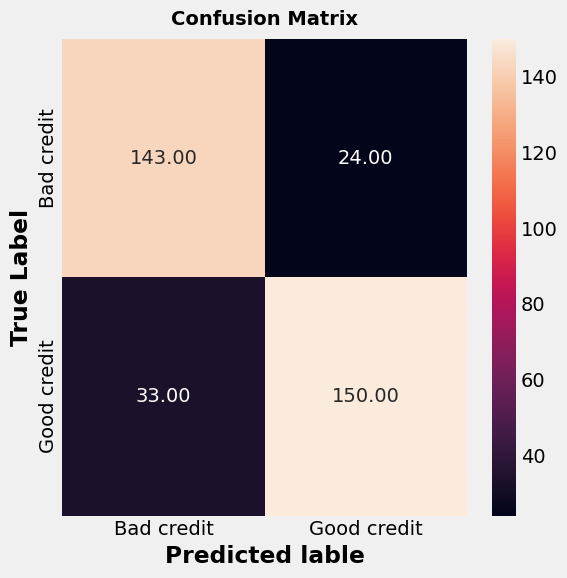

For model RFC (np.int64(150), np.int64(24), np.int64(33), np.int64(143))
##########################################################


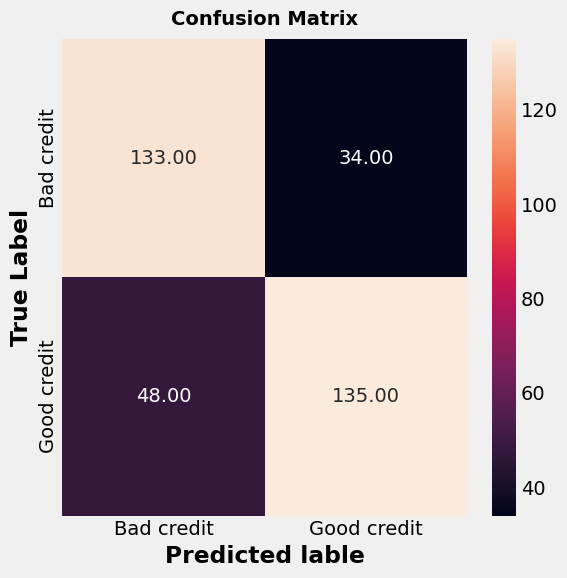

For model DT (np.int64(135), np.int64(34), np.int64(48), np.int64(133))
##########################################################


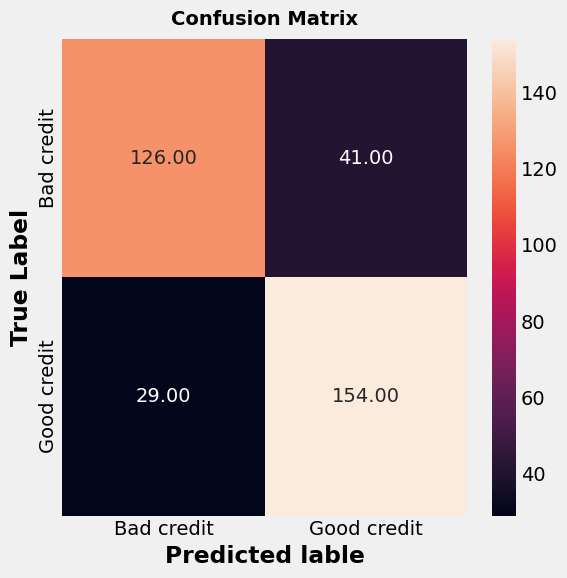

For model knn (np.int64(154), np.int64(41), np.int64(29), np.int64(126))
##########################################################


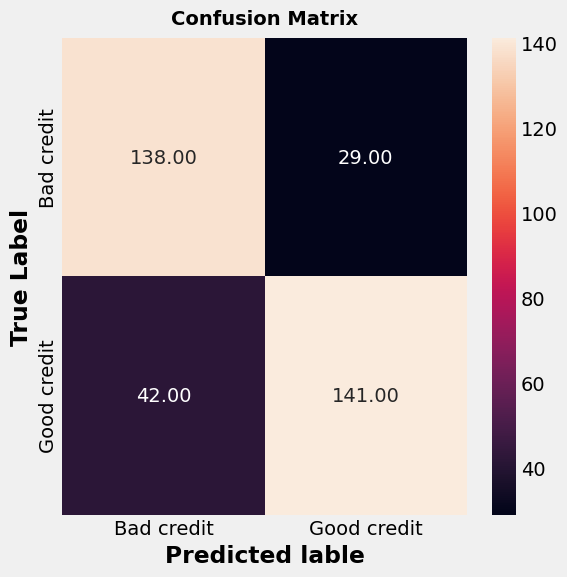

For model GNB (np.int64(141), np.int64(29), np.int64(42), np.int64(138))
##########################################################


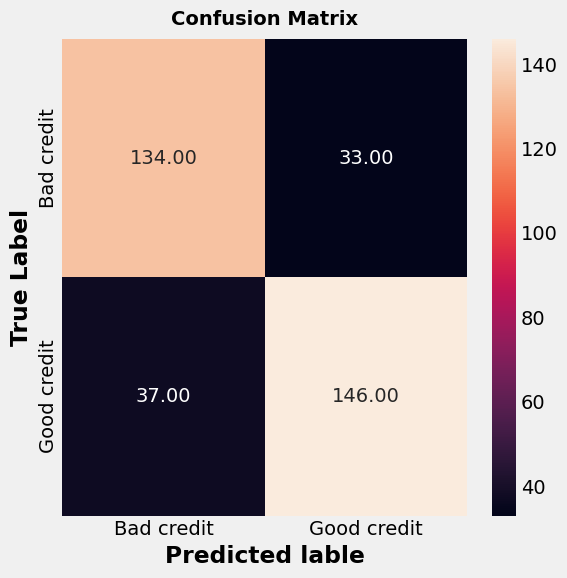

For model SVC (np.int64(146), np.int64(33), np.int64(37), np.int64(134))
##########################################################


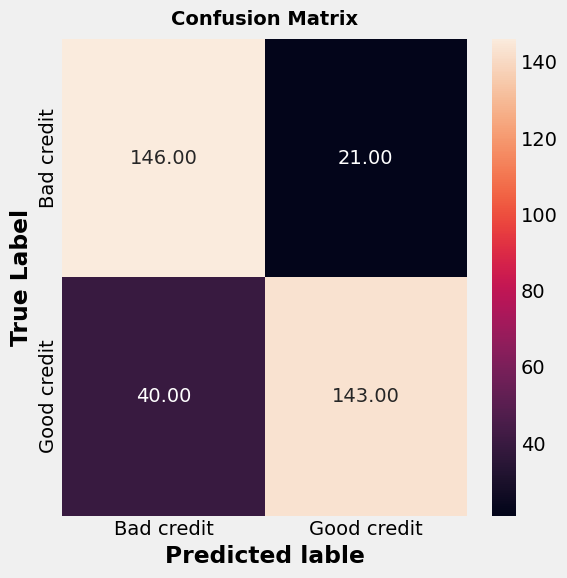

For model GBC (np.int64(143), np.int64(21), np.int64(40), np.int64(146))
##########################################################


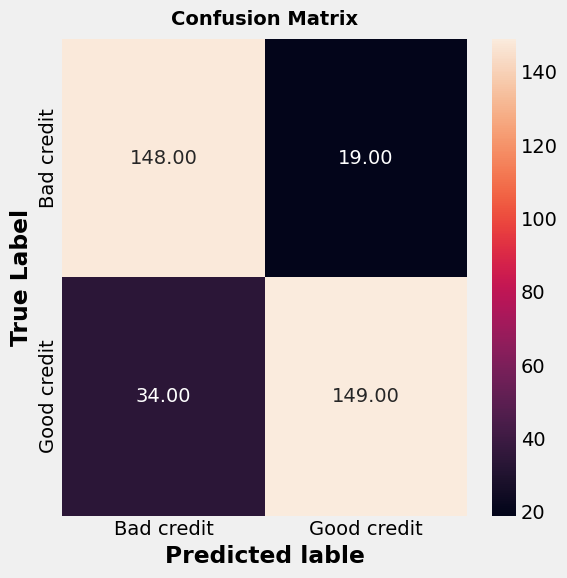

For model XGB (np.int64(149), np.int64(19), np.int64(34), np.int64(148))
##########################################################


In [40]:
# confusion matrix of all six models
for k,model in models_dict.items():
    score = round(model.score(X_tst,y_tst),2)
    predict_y = model.predict(X_tst)
    cm = confusion_matri(y_tst,predict_y)
    print(f"For model {k}", cm)
    print("##########################################################")

In [41]:
# Accuracy of all the models
for k,model in models_dict.items():
    score = round(model.score(X_tst,y_tst),2)
    predict_y = model.predict(X_tst)
    print(f"Accuracy score of {k}: ", round(accuracy_score(y_tst,predict_y),2))

Accuracy score of RFC:  0.84
Accuracy score of DT:  0.77
Accuracy score of knn:  0.8
Accuracy score of GNB:  0.8
Accuracy score of SVC:  0.8
Accuracy score of GBC:  0.83
Accuracy score of XGB:  0.85


# Conclusions:

> In our exploratory data analysis, we found that all continuos features were well imporant while we removed three features due to non-importance in our dataset

> We encoded data using get_dummies of pandas which is nothing but the one hot encoding method.

> we found that there is no significant correlation between features of dataset.

> We figured out outliers in dataset using Box plot method but we neglected due to scaling of dataset.

> We built 7 different models to know classificaiton accuracy of given dataset

> For logistics regression model, we recieved 80% Maximum accuracy with imbalanced classes. we also tries to recify cut-off probability in logistics regression but that did not work as well.

> As our dataset was imabalanced, in second approch we applied SMOTE over sampling stategy to balance the classes

> Then we built six different models using for looping technique, among these six models we found random forest model perform really well than others.

> Reason random forest perform well with 84% accuracy, that could be scaling, balanced classes and n_estimators being 500.

> Here XGB perform less compared to RF and eveb GBC, that is something to notice. here we did not do hyper-parameters tuning with XGB. that can be possible reasom behind XGB did not perform well enough.